In [1]:
import awkward as ak 
import numpy as np
import matplotlib.pyplot as plt
import fastjet
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
import dask_awkward as dak
import hist.dask as hda
import uproot
from ak_tools import ak_equals
import pickle
import matplotlib as mpl

In [2]:
events = NanoEventsFactory.from_root( 
    {"../../Data/rv02-02-03.sv02-02-03.mILD_l5_o1_v02_nobg.E500-TDR_ws.I403001.Pe2e2hh"
     ".eL.pR.n000.d_dstm_15806_0_patched_collections_edm4hep.root"
    :"events"},
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/usr/local/lib/python3.8/dist-packages/cppyy_backend/loader.py:139: UserWarning: No precompiled header available (/usr/local/lib/python3.8/dist-packages/cppyy_backend/etc not writable, set CLING_STANDARD_PCH); this may impact performance.
  warnings.warn('No precompiled header available (%s); this may impact performance.' % msg)
/home/jbrewster/.local/lib/python3.8/site-packages/numba/core/cpu.py:99: UserWarning: Numba extension module 'cppyy.numba_ext' failed to load due to 'ModuleNotFoundError(No module named 'llvmlite.llvmpy')'.
  numba.core.entrypoints.init_all()


FileNotFoundError: file not found

    '../Data/rv02-02-03.sv02-02-03.mILD_l5_o1_v02_nobg.E500-TDR_ws.I403001.Pe2e2hh.eL.pR.n000.d_dstm_15806_0_patched_collections_edm4hep.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


In [11]:
# set up needed arrays
file = uproot.open("../../Data/rv02-02-03.sv02-02-03.mILD_l5_o1_v02_nobg.E500-TDR_ws.I403001.Pe2e2hh"
     ".eL.pR.n000.d_dstm_15806_0_patched_collections_edm4hep.root")

evs = file['events']
uproot_parinds = (evs[f'_MCParticlesSkimmed_parents/_MCParticlesSkimmed_parents.index']).array()
uproot_daughinds = (evs[f'_MCParticlesSkimmed_daughters/_MCParticlesSkimmed_daughters.index']).array() 

pshape = events.MCParticlesSkimmed.parents_counts.compute()
par_inds = ak.unflatten(uproot_parinds,ak.flatten(pshape),axis=1)

dshape = events.MCParticlesSkimmed.children_counts.compute()
daugh_inds = ak.unflatten(uproot_daughinds,ak.flatten(dshape),axis=1)

pdgids = events.MCParticlesSkimmed.pdgId.compute()


arr_reco = events.RecoMCTruthLink.reco_index.compute()
arr_mc = events.RecoMCTruthLink.mc_index.compute()
sort_reco = arr_reco[ak.argsort(arr_reco)]
sort_mc = arr_mc[ak.argsort(arr_reco)]

proper_indices = ak.unflatten(sort_mc,ak.flatten(ak.run_lengths(sort_reco),axis=1),axis=1)

pfos = events.PandoraPFOs.compute()
mc = events.MCParticlesSkimmed.compute()

In [12]:
def jet_truehiggs(reco_particles,mc_particles,true_higgs,reco_mc_index,jet_constits_index,condition='pR',pcrit=(50,5)):
    '''
    compares jet constituents to true higgs products 
    
    Parameters:
    ----------
    reco_particles :: array
        array with all the reco particles
    
    mc_particles :: array
        array with all the mc particles
    
    true_higgs :: array 
        array containing the mc indices of all the children of the higgs in each event 
    
    reco_mc_index :: array 
        array containing a list of mc indices for each reco index
    
    jet_constits_index :: array 
        indices of the pfos contained in the jets in the reco particle array
    
    condition :: str (optional)
        'pR' - the link with the closest momentum match is from the true higgs, to within 50% of the reco momentum 
               or 5 GeV, otherwise the closest \Delta R between the two closest momentum matches
               (criteria can be changed with pcrit)
        'p' - the link with the closest momentum match is from the true higgs
        'any' - any of one of the links from reco particles to mc particles is from the true higgs 
        'all' - all of the links from reco particles to mc particles is from the true higgs 
    
    pcrit :: tuple (optional)
        tuple defining the criteria for using momentum when condition = 'pR' as 
        (percent,absolute) FINISH DESCRIPTION
        
    Returns:
    -------
    
    '''
    matrix = False
    
    # throw error if any of the things are not the right lengths
    if not (len(reco_particles) == len(mc_particles) and len(mc_particles) == len(true_higgs) and len(true_higgs) == len(reco_mc_index) and len(reco_mc_index) == len(jet_constits_index)):
        raise ValueError('first 5 arrays must have the same number of events')
    
    jet_mcindices = reco_mc_index[jet_constits_index]
    jet_con_in_higgs = []
    
    if condition == 'pR':
        # complete (right now this is the same as 'p')
        matched_gen = ak.unflatten(mc_particles[ak.flatten(reco_mc_index,axis=2)],ak.flatten(ak.num(reco_mc_index,axis=2)),axis=1)
        
        mc_reco_cartesian = ak.argcartesian({'mc':matched_gen.p,'reco':ak.singletons(reco_particles.p,axis=1)},axis=2)
        mc_p_argmin = ak.singletons(ak.argmin(abs(matched_gen.p[mc_reco_cartesian['mc']] - ak.singletons(reco_particles.p,axis=1)[mc_reco_cartesian['reco']]),axis=2),axis=1)
        
        all_jet_inds = ak.flatten(reco_mc_index[mc_p_argmin],axis=2)[jet_constits_index]
        
        for n in range(len(all_jet_inds)):
            jet_con_in_higgs.append(np.isin(all_jet_inds[n],true_higgs[n]))

        jet_con_in_higgs = ak.Array(jet_con_in_higgs)
        
    elif condition == 'any' or condition == 'all':
        all_jet_inds = ak.flatten(jet_mcindices,axis=2)
        
        jet_con_in_higgs = []

        for n in range(len(all_jet_inds)):
            jet_con_in_higgs.append(np.isin(all_jet_inds[n],true_higgs[n]))

        jet_con_in_higgs = ak.Array(jet_con_in_higgs)
        
        if condition == 'any':
            jet_con_in_higgs = ak.any(ak.unflatten(jet_con_in_higgs,ak.flatten(ak.num(jet_mcindices,axis=2)),axis=1),axis=2)
        else:
            jet_con_in_higgs = ak.all(ak.unflatten(jet_con_in_higgs,ak.flatten(ak.num(jet_mcindices,axis=2)),axis=1),axis=2)
        
    elif condition == 'p':
        matched_gen = ak.unflatten(mc_particles[ak.flatten(reco_mc_index,axis=2)],ak.flatten(ak.num(reco_mc_index,axis=2)),axis=1)
        
        mc_reco_cartesian = ak.argcartesian({'mc':matched_gen.p,'reco':ak.singletons(reco_particles.p,axis=1)},axis=2)
        mc_p_argmin = ak.singletons(ak.argmin(abs(matched_gen.p[mc_reco_cartesian['mc']] - ak.singletons(reco_particles.p,axis=1)[mc_reco_cartesian['reco']]),axis=2),axis=1)
        
        all_jet_inds = ak.flatten(reco_mc_index[mc_p_argmin],axis=2)[jet_constits_index]
                
        if matrix:
            jet_con_in_higgs = ak_equals(all_jet_inds,true_higgs)
        else:
            for n in range(len(all_jet_inds)):
                jet_con_in_higgs.append(np.isin(all_jet_inds[n],true_higgs[n]))

            jet_con_in_higgs = ak.Array(jet_con_in_higgs)
        
    else:
        raise ValueError('condition must be \'p\', \'any\', or \'all\'')
    
    
    return jet_con_in_higgs

In [13]:
def daughter_tree(event,start_ind):
    '''
    returns list of all daughters 
    '''
    curr_ind = ak.Array([-1])
    daugh_ind = ak.Array([start_ind])

    ind_lst = []

    flag = True

    while flag:
        curr_ind = daugh_ind

        daugh_ind = np.unique(ak.flatten(daugh_inds[event][curr_ind],axis=-1))

        ind_lst.append(list(curr_ind))

        if len(daugh_ind) == 0:
            flag = False 

    return ind_lst

In [14]:
%%time
full_run = False

if full_run:
    higgs_daughter_tree_0 = []
    higgs_daughter_tree_1 = []
    start_inds = ak.local_index(pdgids)[pdgids == 25]

    for event in range(len(pdgids)):

        higgs_daughter_tree_0.append(daughter_tree(event,start_inds[event][0]))
        higgs_daughter_tree_1.append(daughter_tree(event,start_inds[event][1]))

        if event % 1000 == 0:
            print(event)

    higgs_daughter_tree_arr_0 = ak.Array(higgs_daughter_tree_0)
    higgs_daughter_tree_arr_1 = ak.Array(higgs_daughter_tree_1)

    higgs_children_0 = ak.flatten(higgs_daughter_tree_arr_0,axis=2)
    higgs_children_1 = ak.flatten(higgs_daughter_tree_arr_1,axis=2)
else:
    higgs_children_0 = pickle.load(open('higgs_children_0.pickle','rb'))
    higgs_children_1 = pickle.load(open('higgs_children_1.pickle','rb'))
    higgs_daughter_tree_arr_0 = pickle.load(open('higgs_daughter_tree_arr_0.pickle','rb'))
    higgs_daughter_tree_arr_1 = pickle.load(open('higgs_daughter_tree_arr_1.pickle','rb'))

CPU times: user 7.09 ms, sys: 111 ms, total: 118 ms
Wall time: 289 ms


In [15]:
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)
muonsevent_c = muonsevent.compute()

jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)

pfopair = dak.argcombinations(events.PandoraPFOs, 2, fields=["p1", "p2"])

all_muons_mask = (abs(events.PandoraPFOs[pfopair.p1].pdgId) == 13) & (abs(events.PandoraPFOs[pfopair.p2].pdgId) == 13)

invmass = (events.PandoraPFOs[pfopair.p1][all_muons_mask] + events.PandoraPFOs[pfopair.p2][all_muons_mask]).mass

inds = dak.singletons(dak.argmin(abs(invmass - 91.2), axis=1))


mu1ind = pfopair.p1[all_muons_mask][inds]
mu2ind = pfopair.p2[all_muons_mask][inds]

In [18]:
m1 = mu1ind[muonsevent].compute()
m2 = mu2ind[muonsevent].compute()

p = events.PandoraPFOs[muonsevent].compute()

In [19]:
%%time
x = []
y = []
z = []
E = []

local_inds = ak.local_index(p)
total_mask = ((ak_equals(local_inds, m1)) | (ak_equals(local_inds, m2))) != True

for n in range(len(p)):
    x.append(np.array(p.x[n][total_mask[n]]))
    y.append(np.array(p.y[n][total_mask[n]]))
    z.append(np.array(p.z[n][total_mask[n]]))
    E.append(np.array(p.E[n][total_mask[n]]))

x = ak.Array(x)
y = ak.Array(y)
z = ak.Array(z)
E = ak.Array(E)

# total time: 45.2 s

CPU times: user 41.4 s, sys: 1.03 s, total: 42.4 s
Wall time: 50.5 s


In [20]:
select_pfos = ak.zip(
    {
        'px': x,
        'py': y,
        'pz': z,
        'E': E,
    },
    with_name="LorentzVector",
)

select_clst = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=4)

jets = ak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [21]:
pfo_index = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituent_index(njets=4)

In [22]:
def reshape(arr):
    '''
    reshapes stuff after combinations to be sorted correctly 
    '''
    slicing = ak.Array(len(jets)*[[[0,5],[1,4],[2,3]]])
    return ak.unflatten(arr[ak.flatten(slicing,axis=2)],ak.flatten(ak.num(slicing,axis=2)),axis=1)

In [23]:
def best_jet_pairs(jets,jetpair,reco_particles=None,mc_particles=None,true_higgs=None,reco_mc_index=None,pfo_index=None,metric='justmass'):
    '''
    '''
    if metric == 'justmass':
        invmass = (jets[jetpair.jet1] + jets[jetpair.jet2]).mass
        higgs_mass = 125*ak.ones_like(reshape(invmass))
        best_jets = ak.argmin(ak.sum((higgs_mass - reshape(invmass))**2,axis=2),axis=1)

        jet_inds = ak.firsts(reshape(ak.concatenate([ak.singletons(jetpair.jet1,axis=-1),
                                             ak.singletons(jetpair.jet2,axis=-1)],
                                    axis=2))[ak.singletons(best_jets)])
        
    elif metric == 'toline':
        invmass = (jets[jetpair.jet1] + jets[jetpair.jet2]).mass

        line = ak.Array(len(invmass)*[3*[[-1,1]]]) * (np.sqrt(2)/2)
        best_jets = ak.argmin(ak.sum(line*reshape(invmass),axis=2),axis=1)

        jet_inds = ak.firsts(reshape(ak.concatenate([ak.singletons(jetpair.jet1,axis=-1),
                                             ak.singletons(jetpair.jet2,axis=-1)],
                                    axis=2))[ak.singletons(best_jets)])
        
    elif metric == 'mclink':
#         if reco_particles==None or mc_particles==None or true_higgs==None or reco_mc_index==None or pfo_index==None:
#             raise ValueError('if metric = \'mclink\', need value for reco_particles,mc_particles,true_higgs,reco_mc_index,pfo_index')
        
        from_higgs_0 = []
        for n in range(4):
            pfo_index_jet_n = ak.firsts(pfo_index[ak.local_index(pfo_index,axis=1) == n])

            four_jet_con = jet_truehiggs(reco_particles,
                                         mc_particles,
                                         true_higgs,
                                         reco_mc_index,
                                         pfo_index_jet_n,
                                         'p')

            from_higgs_0.append(ak.num(four_jet_con[four_jet_con],axis=1)/ak.num(four_jet_con,axis=1))
#             print((ak.num(four_jet_con[four_jet_con],axis=1)/ak.num(four_jet_con,axis=1))[-5])


        link_weights = ak.concatenate(ak.singletons(from_higgs_0,axis=-1),axis=1)

        jet_higgs_0_max0 = ak.argmax(link_weights,axis=1)
        jet_weights_max = (ak.local_index(link_weights) == jet_higgs_0_max0)
        jet_higgs_0_max1 = ak.firsts(ak.local_index(link_weights)[jet_weights_max != True][ak.singletons(ak.argmax(link_weights[jet_weights_max != True],axis=1),axis=-1)],axis=-1)

        jet_higgs_0_min0 = ak.argmin(link_weights,axis=1)
        jet_weights_min = (ak.local_index(link_weights) == jet_higgs_0_min0)
        jet_higgs_0_min1 = ak.firsts(ak.local_index(link_weights)[jet_weights_min != True][ak.singletons(ak.argmin(link_weights[jet_weights_min != True],axis=1),axis=-1)],axis=-1)


        jet_inds = ak.concatenate([ak.singletons(ak.concatenate([ak.singletons(jet_higgs_0_max0,axis=-1),
                                                                 ak.singletons(jet_higgs_0_max1,axis=-1)],axis=1),axis=0),
                                   ak.singletons(ak.concatenate([ak.singletons(jet_higgs_0_min0,axis=-1),
                                                                 ak.singletons(jet_higgs_0_min1,axis=-1)],axis=1),axis=0)],axis=1)

    return jet_inds


In [24]:
# using linking to do pairing 
jetpair = ak.argcombinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs
jet_inds = best_jet_pairs(jets,
                          jetpair,
                          pfos[muonsevent_c][total_mask],
                          mc[muonsevent_c],
                          higgs_children_0[muonsevent_c],
                          proper_indices[muonsevent_c][total_mask],
                          pfo_index,
                          metric='mclink')

In [25]:
# pairing by an analytic method
# jetpair = ak.argcombinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs
# jet_inds = best_jet_pairs(jets,jetpair,metric='justmass')
# jet_inds = best_jet_pairs(jets,jetpair,metric='toline')


In [26]:
grouped_pfo_index = ak.flatten(ak.unflatten(pfo_index[ak.flatten(jet_inds,axis=2)],ak.flatten(ak.num(jet_inds,axis=2)),axis=1),axis=3)

In [27]:
even_jet_mask = ak.local_index(grouped_pfo_index,axis=1) % 2 == 0
odd_jet_mask = ak.local_index(grouped_pfo_index,axis=1) % 2 == 1

In [28]:
best_invmasses_j0 = (jets[ak.firsts(jet_inds[even_jet_mask],axis=1)[even_jet_mask]] + jets[ak.firsts(jet_inds[even_jet_mask],axis=1)[odd_jet_mask]]).mass
best_invmasses_j1 = (jets[ak.firsts(jet_inds[odd_jet_mask],axis=1)[even_jet_mask]] + jets[ak.firsts(jet_inds[odd_jet_mask],axis=1)[odd_jet_mask]]).mass

best_invmasses = ak.concatenate([best_invmasses_j0,best_invmasses_j1],axis=1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


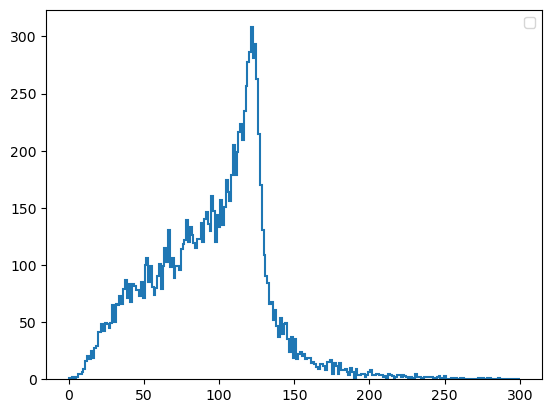

In [29]:
nbins = 250
mini = 0 
maxi = 300

plt.close(1);plt.figure(1)
plt.hist(ak.flatten(best_invmasses),
         #ak.sum(ak.firsts(best_invmasses),axis=1),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=1.5,
         label='')

plt.legend()

In [30]:
# pickle.dump(higgs_children_0,open('higgs_children_0.pickle','wb'))
# pickle.dump(higgs_children_1,open('higgs_children_1.pickle','wb'))
# pickle.dump(higgs_daughter_tree_arr_0,open('higgs_daughter_tree_arr_0.pickle','wb'))
# pickle.dump(higgs_daughter_tree_arr_1,open('higgs_daughter_tree_arr_1.pickle','wb'))

In [31]:
jet_con_in_higgs = ak.Array([{'pfo_higgs_0':jet_truehiggs(pfos[muonsevent_c][total_mask],
                                 mc[muonsevent_c],
                                 higgs_children_0[muonsevent_c],
                                 proper_indices[muonsevent_c][total_mask],
                                 ak.firsts(grouped_pfo_index[even_jet_mask]),
                                 'p'),
                      'pfo_higgs_1':jet_truehiggs(pfos[muonsevent_c][total_mask],
                                 mc[muonsevent_c],
                                 higgs_children_0[muonsevent_c],
                                 proper_indices[muonsevent_c][total_mask],
                                 ak.firsts(grouped_pfo_index[odd_jet_mask]),
                                 'p')},
                      {'pfo_higgs_0':jet_truehiggs(pfos[muonsevent_c][total_mask],
                                 mc[muonsevent_c],
                                 higgs_children_1[muonsevent_c],
                                 proper_indices[muonsevent_c][total_mask],
                                 ak.firsts(grouped_pfo_index[even_jet_mask]),
                                 'p'),
                      'pfo_higgs_1':jet_truehiggs(pfos[muonsevent_c][total_mask],
                                 mc[muonsevent_c],
                                 higgs_children_1[muonsevent_c],
                                 proper_indices[muonsevent_c][total_mask],
                                 ak.firsts(grouped_pfo_index[odd_jet_mask]),
                                 'p')}])

In [32]:
# frac_p0_t0 = ak.num(jet_con_in_higgs['pfo_higgs_0'][0][jet_con_in_higgs['pfo_higgs_0'][0]])/ak.num(jet_con_in_higgs['pfo_higgs_0'][0])
# frac_p0_t1 = ak.num(jet_con_in_higgs['pfo_higgs_0'][1][jet_con_in_higgs['pfo_higgs_0'][1]])/ak.num(jet_con_in_higgs['pfo_higgs_0'][1])

# frac_p1_t0 = ak.num(jet_con_in_higgs['pfo_higgs_1'][0][jet_con_in_higgs['pfo_higgs_1'][0]])/ak.num(jet_con_in_higgs['pfo_higgs_1'][0])
# frac_p1_t1 = ak.num(jet_con_in_higgs['pfo_higgs_1'][1][jet_con_in_higgs['pfo_higgs_1'][1]])/ak.num(jet_con_in_higgs['pfo_higgs_1'][1])

# j0 is the same as p0 
# t refers to the true higgs and p refers to pfo higgs
total_j0_E = ak.sum(pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[even_jet_mask])].E,axis=1)
Efrac_p0_t0 = ak.sum(pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[even_jet_mask])].E[jet_con_in_higgs['pfo_higgs_0'][0]],axis=1)/total_j0_E
Efrac_p0_t1 = ak.sum(pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[even_jet_mask])].E[jet_con_in_higgs['pfo_higgs_0'][1]],axis=1)/total_j0_E

total_j1_E = ak.sum(pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[odd_jet_mask])].E,axis=1)
Efrac_p1_t0 = ak.sum(pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[odd_jet_mask])].E[jet_con_in_higgs['pfo_higgs_1'][0]],axis=1)/total_j1_E
Efrac_p1_t1 = ak.sum(pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[odd_jet_mask])].E[jet_con_in_higgs['pfo_higgs_1'][1]],axis=1)/total_j1_E


In [174]:
Efracs_t0 = ak.concatenate([ak.singletons(Efrac_p0_t0),ak.singletons(Efrac_p1_t0)],axis=1)

large_portion = ak.argmax(Efracs_t0,axis=1)

# tells pfo_higgs_0 whether to choose 0 or 1 (i.e. true higgs 0 or 1)
large_portion_mask = ak.local_index(Efracs_t0,axis=1) == large_portion

In [176]:
# grabs the mask that tells you whether each pfo is in the true higgs for 
# true higgs we've matched up the reco higgs to 
jet_con_in_higgs_best_mask_0 = ak.firsts(
    ak.concatenate(
        [ak.singletons(jet_con_in_higgs['pfo_higgs_0'][0]),
         ak.singletons(jet_con_in_higgs['pfo_higgs_0'][1])],
        axis=1)[large_portion_mask],
    axis=1)

jet_con_in_higgs_best_mask_1 = ak.firsts(
    ak.concatenate(
        [ak.singletons(jet_con_in_higgs['pfo_higgs_1'][0]),
         ak.singletons(jet_con_in_higgs['pfo_higgs_1'][1])],
        axis=1)[large_portion_mask != True],
    axis=1)


In [177]:
# there may be a small bug here

# grabs the energy fraction for each reco higgs matched to the true higgs
energy_frac_pfo_0 = ak.sum(
    pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[even_jet_mask])].E[jet_con_in_higgs_best_mask_0],
    axis=1,
) / total_j0_E

energy_frac_pfo_1 = ak.sum(
    pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[odd_jet_mask])].E[jet_con_in_higgs_best_mask_1],
    axis=1
)/total_j1_E


In [37]:
# reformats the above to be in terms of the true higgs instead of the reco higgs
energy_frac_true_h0 = ak.concatenate([ak.singletons(energy_frac_pfo_0),ak.singletons(energy_frac_pfo_1)],axis=1)[large_portion_mask]
energy_frac_true_h1 = ak.concatenate([ak.singletons(energy_frac_pfo_0),ak.singletons(energy_frac_pfo_1)],axis=1)[large_portion_mask != True]


Text(0.5, 1.0, 'Clustering Efficiency with Jet Pairs Selected by Invariant Mass')

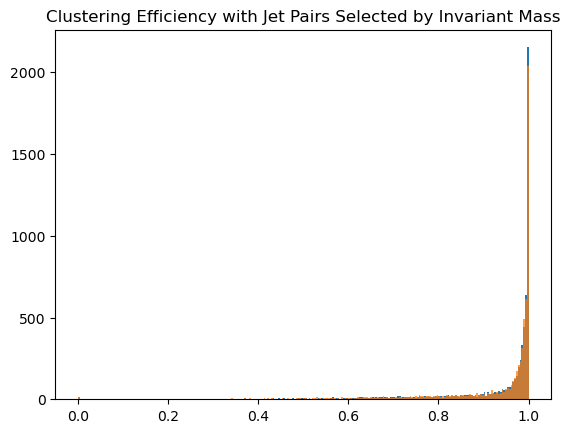

In [38]:
plt.close(1);plt.figure(1)
plt.hist(energy_frac_true_h0,bins=250,alpha=1)
plt.hist(energy_frac_true_h1,bins=250,alpha=0.75)
plt.title('Clustering Efficiency with Jet Pairs Selected by Invariant Mass')

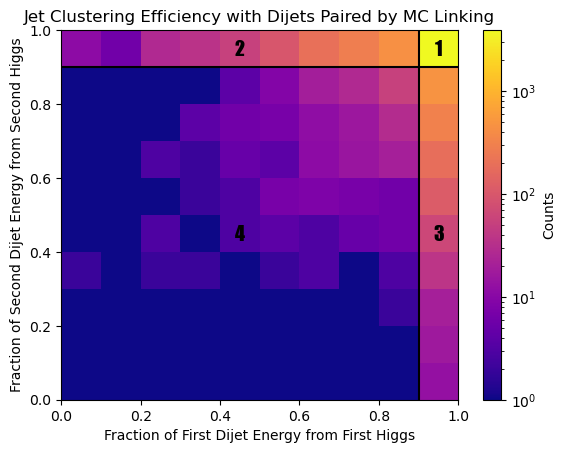

In [39]:
fig = plt.figure()
ax = fig.add_subplot()
nbins = 10

nums = plt.hist2d(np.array(ak.firsts(energy_frac_true_h0)),
                  np.array(ak.firsts(energy_frac_true_h1)),
                  norm=mpl.colors.LogNorm(clip=True),
                  cmap = 'plasma',
                  bins=nbins)

plt.plot([0.9,0.9],[0,1],'black')
plt.plot([0,1],[0.9,0.9],'black')

plt.xlabel('Fraction of First Dijet Energy from First Higgs')
plt.ylabel('Fraction of Second Dijet Energy from Second Higgs')
plt.title('Jet Clustering Efficiency with Dijets Paired by MC Linking')
plt.text(0.95,0.95,'1',fontfamily='fantasy',size='x-large',ha='center',va='center')
plt.text(0.45,0.95,'2',fontfamily='fantasy',size='x-large',ha='center',va='center')
plt.text(0.95,0.45,'3',fontfamily='fantasy',size='x-large',ha='center',va='center')
plt.text(0.45,0.45,'4',fontfamily='fantasy',size='x-large',ha='center',va='center')
plt.colorbar(label='Counts')
# plt.tight_layout()
# plt.savefig('2dhistcheatlink')

In [40]:
thres = 1-1/nbins
r1 = (ak.firsts(energy_frac_true_h0) >= thres) & (ak.firsts(energy_frac_true_h1) >= thres)
r2 = (ak.firsts(energy_frac_true_h0) >= thres) & (ak.firsts(energy_frac_true_h1) < thres)
r3 = (ak.firsts(energy_frac_true_h0) < thres) & (ak.firsts(energy_frac_true_h1) >= thres)
r4 = (ak.firsts(energy_frac_true_h0) < thres) & (ak.firsts(energy_frac_true_h1) < thres)

In [41]:
print('r1:',round(len(r1[r1])/len(r1),3),'r2:',round(len(r2[r2])/len(r2),3),'r3:',round(len(r3[r3])/len(r3),3),'r4:',round(len(r4[r4])/len(r4),3))

r1: 0.591 r2: 0.187 r3: 0.173 r4: 0.049


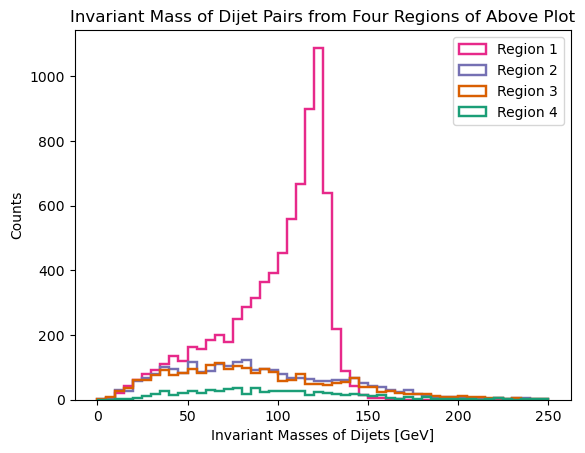

In [42]:
cmap = mpl.colormaps['Dark2']
cmap2 = mpl.colormaps['plasma']

nbins = 50 # 75 for poster plot
mini = 0 
maxi = 250
density = False
sep_r2_r3 = False
linewidth = 1.75 # 1.5 for poster

plt.close(1);plt.figure(1)

plt.hist(ak.flatten(best_invmasses[r1],axis=1),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=linewidth,
         density=density,
         color=cmap(0.4),
         label='Region 1')

if sep_r2_r3:
    plt.hist(best_invmasses[large_portion_mask][r2],
             bins=nbins,
             range=(mini,maxi),
             histtype='step',
             linewidth=1.5,
             density=density,
             label='good r2')

    plt.hist(best_invmasses[large_portion_mask!=True][r3],
             bins=nbins,
             range=(mini,maxi),
             histtype='step',
             linewidth=1.5,
             density=density,
             label='good r3')

    plt.hist(best_invmasses[large_portion_mask!=True][r2],
             bins=nbins,
             range=(mini,maxi),
             histtype='step',
             linewidth=1.5,
             density=density,
             label='bad r2')

    plt.hist(best_invmasses[large_portion_mask][r3],
             bins=nbins,
             range=(mini,maxi),
             histtype='step',
             linewidth=1.5,
             density=density,
             label='bad r3')
else:
    plt.hist(ak.flatten(best_invmasses[r2],axis=1),
             bins=nbins,
             range=(mini,maxi),
             histtype='step',
             linewidth=linewidth,
             density=density,
             color=cmap(0.3),
             label='Region 2')

    plt.hist(ak.flatten(best_invmasses[r3],axis=1),
             bins=nbins,
             range=(mini,maxi),
             histtype='step',
             linewidth=linewidth,
             density=density,
             color=cmap(0.2),
             label='Region 3')

plt.hist(ak.flatten(best_invmasses[r4],axis=1),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=linewidth,
         density=density,
         color=cmap(0.1),
         label='Region 4')

plt.xlabel('Invariant Masses of Dijets [GeV]')
if density:
    plt.ylabel('Counts Normalized by Area Under Curve')
else:
    plt.ylabel('Counts')

plt.title('Invariant Mass of Dijet Pairs from Four Regions of Above Plot')
plt.legend()

# plt.savefig('higgsmass4_unnorm')

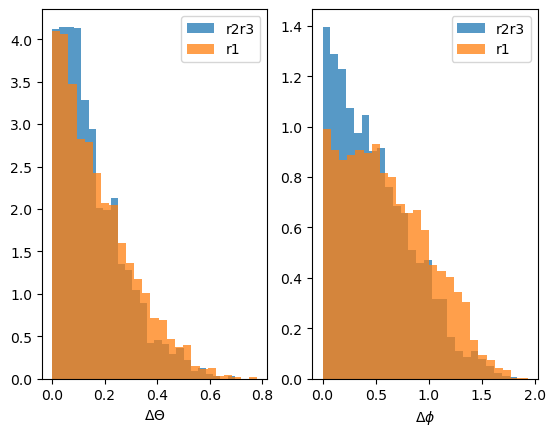

In [75]:
nbins = 25
alpha = 0.75
density = True

jet_combs = ak.combinations(jets,2,fields=['j1','j2'])

fig,axs = plt.subplots(1,2)

axs[0].hist(ak.min(abs(jet_combs.j1.theta - jet_combs.j2.theta),axis=1)[r2|r3],
         bins=nbins,
         alpha=alpha,
         density=density,
         label='r2r3')

axs[0].hist(ak.min(abs(jet_combs.j1.theta - jet_combs.j2.theta),axis=1)[r1],
         bins=nbins,
         alpha=alpha,
         density=density,
         label='r1')

axs[0].legend()
axs[0].set_xlabel('$\Delta \Theta $')

axs[1].hist(ak.min(abs(jet_combs.j1.phi - jet_combs.j2.phi),axis=1)[r2|r3],
         bins=nbins,
         alpha=alpha,
         density=density,
         label='r2r3')

axs[1].hist(ak.min(abs(jet_combs.j1.phi - jet_combs.j2.phi),axis=1)[r1],
         bins=nbins,
         alpha=alpha,
         density=density,
         label='r1')

axs[1].set_xlabel('$\Delta \phi $')

axs[1].legend()

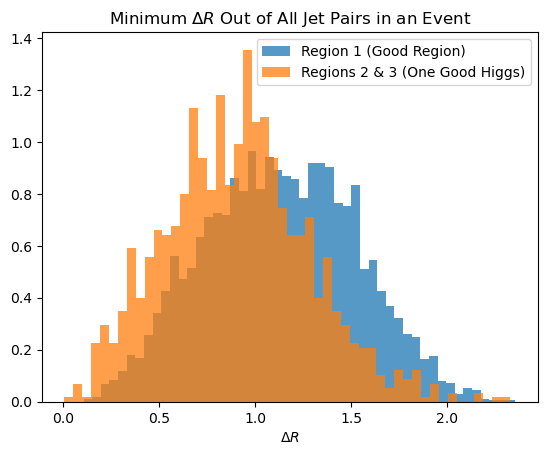

In [163]:
# do the above plot but with delta R 
density = True
alpha = 0.75
nbins = 50

min_R = ak.min(ak.flatten(jets.metric_table(jets)[jets.metric_table(jets) != 0],axis=2),axis=1)

plt.close(1);plt.figure(1)
plt.hist(min_R[r1],density=density,alpha=alpha,bins=nbins,label='Region 1 (Good Region)')
plt.hist(min_R[r2|r2],density=density,alpha=alpha,bins=nbins,label='Regions 2 & 3 (One Good Higgs)')

plt.xlabel('$\Delta R$')
plt.title('Minimum $\Delta R$ Out of All Jet Pairs in an Event')

plt.legend()

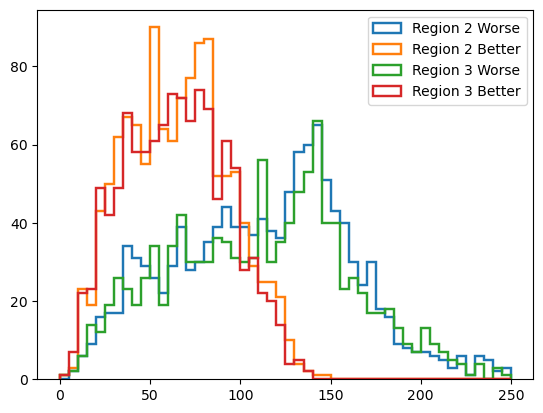

In [153]:
cmap = mpl.colormaps['Dark2']
cmap2 = mpl.colormaps['plasma']

nbins = 50 # 75 for poster plot
mini = 0 
maxi = 250
density = False
sep_r2_r3 = False
linewidth = 1.75 # 1.5 for poster

worse_higgs_ind = ak.singletons(ak.argmin(ak.concatenate([energy_frac_true_h0,energy_frac_true_h1],axis=1),axis=1))
better_higgs_ind = ak.singletons(ak.argmax(ak.concatenate([energy_frac_true_h0,energy_frac_true_h1],axis=1),axis=1))

plt.close(1);plt.figure(1)

plt.hist(ak.flatten(best_invmasses[worse_higgs_ind][r2],axis=1),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=linewidth,
         density=density,
#          color=cmap(0.4),
         label='Region 2 Worse')

plt.hist(ak.flatten(best_invmasses[better_higgs_ind][r2],axis=1),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=linewidth,
         density=density,
#          color=cmap(0.4),
         label='Region 2 Better')

plt.hist(ak.flatten(best_invmasses[worse_higgs_ind][r3],axis=1),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=linewidth,
         density=density,
#          color=cmap(0.4),
         label='Region 3 Worse')

plt.hist(ak.flatten(best_invmasses[better_higgs_ind][r3],axis=1),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=linewidth,
         density=density,
#          color=cmap(0.4),
         label='Region 3 Better')

plt.legend()

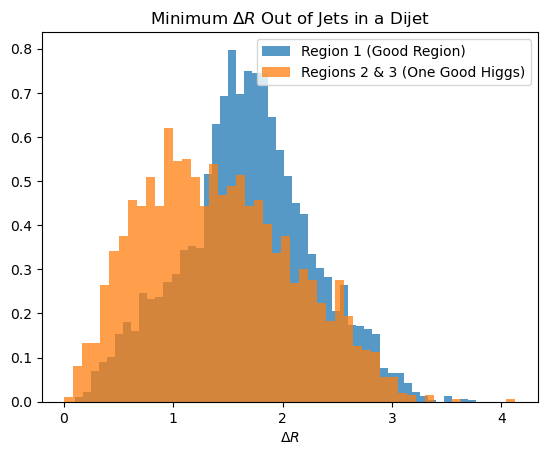

In [164]:
density = True
alpha = 0.75
nbins = 50

dijet_combs = ak.cartesian(
    {'d1':ak.firsts(jet_inds[even_jet_mask]),'d2':ak.firsts(jet_inds[odd_jet_mask])}
    ,axis=1)

h0_delta_R = ak.firsts(jets[ak.firsts(jet_inds[even_jet_mask])][even_jet_mask].metric_table(jets[ak.firsts(jet_inds[even_jet_mask])][odd_jet_mask]))

h1_delta_R = ak.firsts(jets[ak.firsts(jet_inds[odd_jet_mask])][even_jet_mask].metric_table(jets[ak.firsts(jet_inds[odd_jet_mask])][odd_jet_mask]))

worse_higgs_ind = ak.singletons(ak.argmin(ak.concatenate([energy_frac_true_h0,energy_frac_true_h1],axis=1),axis=1))
worse_higgs_delta_R = ak.concatenate([h0_delta_R,h1_delta_R],axis=1)[worse_higgs_ind]

plt.close(1);plt.figure(1)
# plt.hist(worse_higgs_delta_R[r1],density=density,alpha=alpha,bins=nbins,label='Region 1 (Good Region)')
# plt.hist(worse_higgs_delta_R[r2|r3],density=density,alpha=alpha,bins=nbins,label='Regions 2 & 3 (One Good Higgs)')

plt.hist(ak.min(ak.concatenate([h0_delta_R,h1_delta_R],axis=1)[r1],axis=1),density=density,alpha=alpha,bins=nbins,label='Region 1 (Good Region)')
plt.hist(ak.min(ak.concatenate([h0_delta_R,h1_delta_R],axis=1)[r2|r3],axis=1),density=density,alpha=alpha,bins=nbins,label='Regions 2 & 3 (One Good Higgs)')

plt.xlabel('$\Delta R$')
plt.title('Minimum $\Delta R$ Out of Jets in a Dijet')

plt.legend()

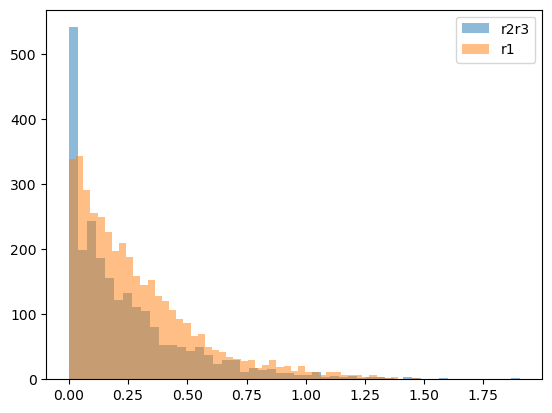

In [44]:
# I do not know what this graph is 
dijet_combs = ak.cartesian({'d1':ak.firsts(jet_inds[even_jet_mask]),'d2':ak.firsts(jet_inds[odd_jet_mask])},axis=1)
plt.close(1);plt.figure(1)
plt.hist(ak.min(abs(jets[dijet_combs.d1].theta-jets[dijet_combs.d2].theta),axis=1)[r2|r3],bins=nbins,label='r2r3',alpha=0.5)
plt.hist(ak.min(abs(jets[dijet_combs.d1].theta-jets[dijet_combs.d2].theta),axis=1)[r1],bins=nbins,label='r1',alpha=0.5)
plt.legend()

### Mostly Visualization Plots 

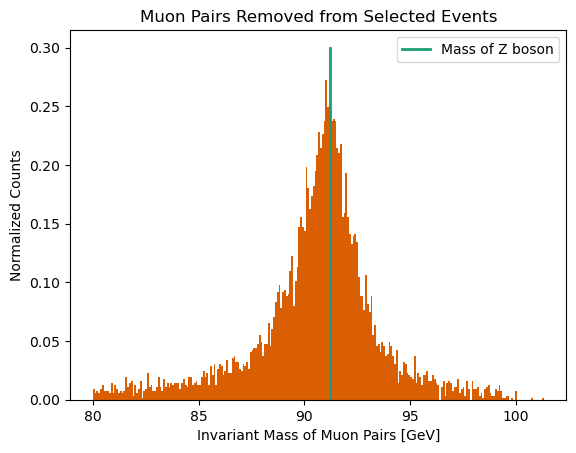

In [58]:
cmap = mpl.colormaps['Dark2']

plt.close(1);plt.figure(1)

nbins = 250

plt.hist(ak.flatten((p[m1]+p[m2]).mass),bins=nbins,density=True,color=cmap(0.2))
plt.plot([91.2,91.2],[0,0.3],label='Mass of Z boson',color=cmap(0.1),linewidth=2)

plt.title('Muon Pairs Removed from Selected Events')
plt.xlabel('Invariant Mass of Muon Pairs [GeV]')
plt.ylabel('Normalized Counts')
plt.legend()
# plt.savefig('remmuons.pdf')

In [ ]:
event = 436 # good events: 5,8,2385,436
# MAKE SURE THESE MASKS ARE RIGHT
# maybe put on log scale for size, also polar?
jet_nojet_pfos = []
for n in range(4):
    jet_nojet_pfos.append(pfos[muonsevent_c][total_mask][ak.firsts(pfo_index[ak.local_index(pfo_index,axis=1) == n])][event])

jet_nojet_pfos.append(pfos[muonsevent_c][total_mask][ak.local_index(pfos[muonsevent_c][total_mask])[ak_equals(ak.local_index(pfos[muonsevent_c][total_mask]),ak.flatten(pfo_index,axis=2)) != True]][event])

cmap = mpl.colormaps['tab20b']
cmap_sel = [0.04,0.2,0.6,0.85,0.9]

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
# ax = fig.add_subplot()
for n in range(5):
    if n != 4:
        color = cmap(cmap_sel[n])
    else:
        color = mpl.colormaps['Set2'](cmap_sel[n])
    
    ax.scatter(jet_nojet_pfos[n].phi,
               jet_nojet_pfos[n].eta,
               s=500*jet_nojet_pfos[n].E/np.max(pfos[muonsevent_c][total_mask][event].E),
               label='Jet' + str(n+1),
               color = color,
               alpha=0.5)
#     ax.scatter(jet_nojet_pfos[n].phi,jet_nojet_pfos[n].eta,s=500*np.log(jet_nojet_pfos[n].E)/np.max(jet_nojet_pfos[n].E),label=str(n))
    
# plt.legend()
# ax.set_xlabel('r')

ax.grid(False)
ax.set_rticks([])
ax.set_xticks([])
ax.set_title('Visualization of Jet Clustering')
plt.axis('off')

# plt.savefig('jetpic.pdf')

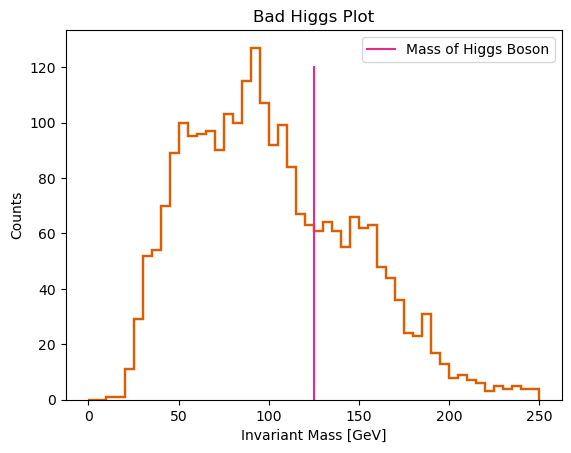

In [56]:
cmap = mpl.colormaps['Dark2']
cmap2 = mpl.colormaps['plasma']

nbins = 50 # 75 for poster plot
mini = 0 
maxi = 250
density = False
sep_r2_r3 = False
linewidth = 1.75 # 1.5 for poster

plt.close(1);plt.figure(1)

# plt.hist(ak.flatten(best_invmasses[r1],axis=1),
#          bins=nbins,
#          range=(mini,maxi),
#          histtype='step',
#          linewidth=linewidth,
#          density=density,
#          color=cmap(0.3))

plt.hist(ak.flatten(best_invmasses[r2],axis=1) + 13,
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=linewidth,
         density=density,
         color=cmap(0.2))

plt.plot([125,125],[0,120],color=cmap(0.4),label='Mass of Higgs Boson')

plt.xlabel('Invariant Mass [GeV]')
if density:
    plt.ylabel('Counts Normalized by Area Under Curve')
else:
    plt.ylabel('Counts')

plt.title('Bad Higgs Plot')
plt.legend()

# plt.savefig('bad_higgs_eg.pdf')

below here is mostly junk I think

There seems to be a problem here... sometimes both of the pfo higgs favour the same truth one. I'm not sure if that's allowed or makes sense at all?? It doesn't seem to always happen so maybe it's okay but I need to check in the ambiguous cases. 

In [374]:
a1 = ak.flatten(proper_indices[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[odd_jet_mask])],axis=2)
a2 = ak.flatten(proper_indices[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[even_jet_mask])],axis=2)

# ak_equals(a1,a2)

(array([4248.,    0., 1631.,    0.,  546.,    0.,  150.,    0.,   50.,
           6.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

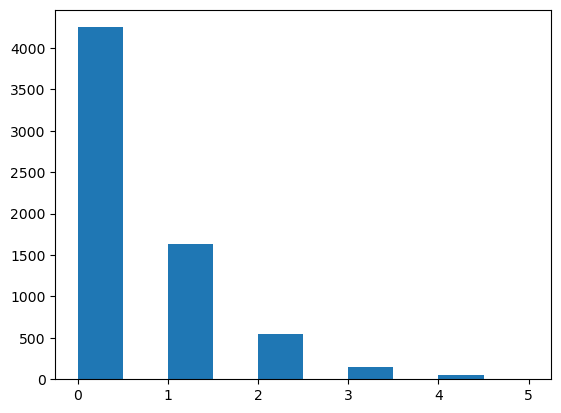

In [393]:
same_mc = ak_equals(jet_con_in_higgs['pfo_higgs_0'][0],jet_con_in_higgs['pfo_higgs_1'][0])
plt.close(1);plt.figure(1)
plt.hist(ak.num(same_mc[same_mc]))

In [409]:
total_j0_E = ak.sum(pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[even_jet_mask])].E,axis=1)
Efrac_p0_t0 = ak.sum(pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[even_jet_mask])].E[jet_con_in_higgs['pfo_higgs_0'][0]],axis=1)/total_j0_E


total_j1_E = ak.sum(pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[odd_jet_mask])].E,axis=1)
Efrac_p1_t0 = ak.sum(pfos[muonsevent_c][total_mask][ak.firsts(grouped_pfo_index[odd_jet_mask])].E[jet_con_in_higgs['pfo_higgs_1'][0]],axis=1)/total_j1_E


In [410]:
ak.concatenate([ak.singletons(Efrac_p0_t0),ak.singletons(Efrac_p1_t0)],axis=1)

<Array [[1, 0.0202], [...], ..., [0.0715, 0.361]] type='6631 * var * float32'>

(array([ 11.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   1.,   1.,   3.,   0.,   3.,   2.,   1.,   1.,   0.,
          1.,   2.,   1.,   4.,   3.,   2.,   4.,   3.,   2.,   3.,   1.,
          3.,   4.,   0.,   6.,   3.,   3.,   9.,   3.,   2.,   2.,   5.,
          2.,   8.,   5.,   7.,   3.,   6.,   8.,   2.,   8.,   1.,   9.,
          5.,   4.,   4.,   5.,   5.,   9.,   5.,   8.,  12.,   9.,   6.,
          8.,  11.,  12.,  10.,  18.,  12.,  11.,   9.,  16.,  26.,  15.,
         11.,  12.,  19.,  17.,   9.,  24.,  24.,  20.,  14.,  21.,  33.,
         18.,  26.,  23.,  28.,  38.,  42.,  44.,  41.,  32.,  41.,  42.,
         47.,  45.,  39.,  43.,  40.,  45.,  52.,  65.,  55.,  50.,  55.,
         46.,  52.,  66.,  62.,  65.,  78.,  67.,  81.,  98.,  79., 101.,
        150., 188., 289., 523., 592., 245., 166., 132., 113.,  86.,  87.,
         85.,  82.,  71.,  64.,  68.,  69.,  62.,  47.,  47.,  50.,  48.,
         59.,  46.,  44.,  51.,  39., 

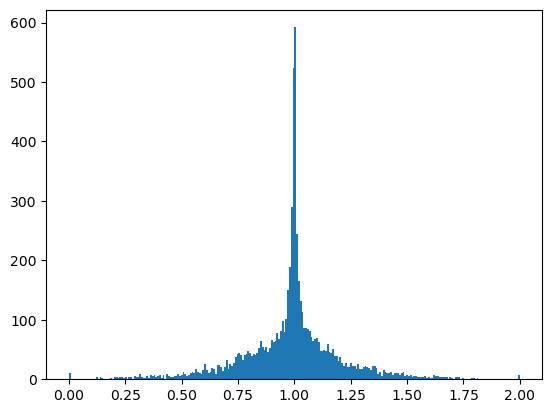

In [411]:
plt.close(1);plt.figure(1)
plt.hist(Efrac_p0_t0 + Efrac_p1_t0,bins=250)

# plt.xlabel()

''

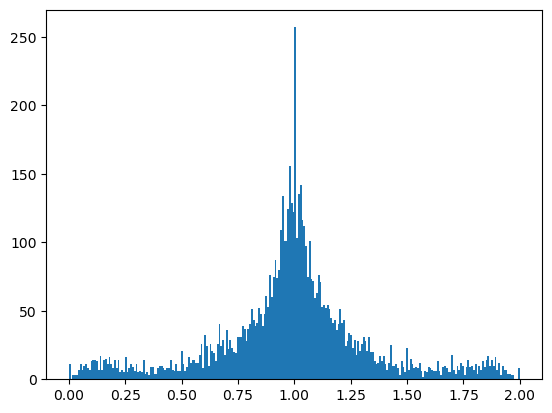

In [412]:
plt.close(1);plt.figure(1)
plt.hist(frac_p0_t0 + frac_p1_t0,bins=250)
''